<a href="https://colab.research.google.com/github/Natasha617/-advanced-machine-learning/blob/main/Ensembles_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!cp '/content/drive/MyDrive/magamed/introduction ML/Ensembles/electricity_train.csv' /content/data.csv

In [87]:
data = pd.read_csv('data.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
data.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [ ]:
data['class'].value_counts()[1]/len(data['class'])

0.4245358492648073

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

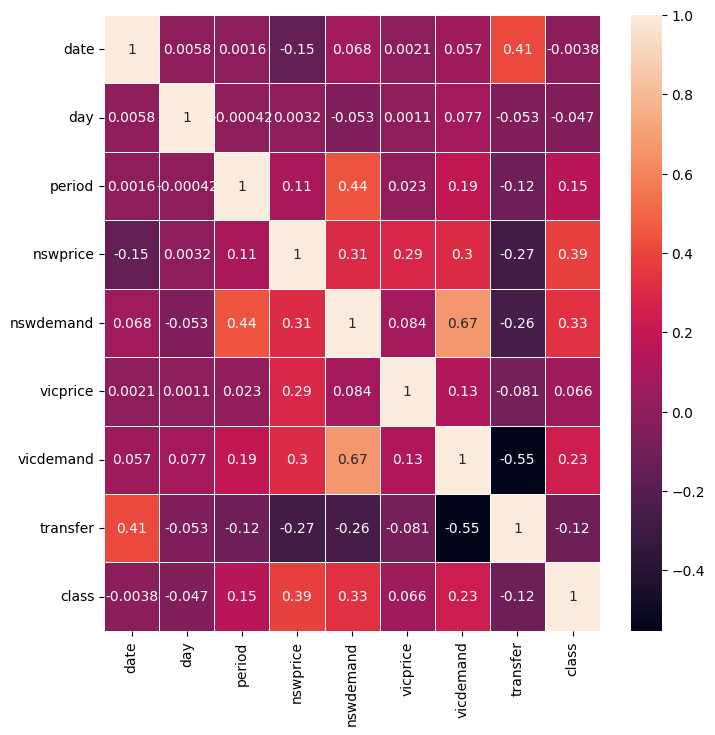

In [ ]:
corrmat = data.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corrmat, annot=True, linewidths=.5)
plt.show()

Постройте гистограммы распределений признаков.

In [ ]:
name_col = data.columns.tolist()
name_col

['date',
 'day',
 'period',
 'nswprice',
 'nswdemand',
 'vicprice',
 'vicdemand',
 'transfer',
 'class']

(array([3.6239e+04, 2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

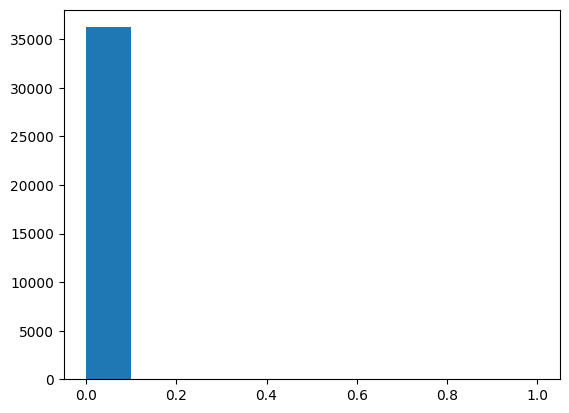

In [ ]:
plt.hist(data['vicprice'])

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разбейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
x_train, x_test, y_train , y_test = train_test_split(data.drop(columns = 'class'), data['class'],test_size=0.2, random_state=21 )

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
randf = RandomForestClassifier(random_state=21).fit(x_train,y_train)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [92]:
from sklearn.metrics import classification_report

In [93]:
target_names = ['class 0', 'class 1']
print(classification_report(y_train, randf.predict(x_train), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      1.000     1.000     1.000     16699
     class 1      1.000     1.000     1.000     12300

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [ ]:
from sklearn.model_selection import GridSearchCV

In [94]:
params_grid = {'n_estimators': [100,300,500],
  'max_leaf_nodes': list(range(6,10)),
  'min_samples_leaf': [1,2,3]}

grid = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=21),
    params_grid,
    verbose=4,
    cv=3)

grid.fit(x_train,y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_
print(best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   2.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.776 total time=   2.1s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   3.8s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   3.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   3.5s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.770 total time=   8.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=   5.8s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.775 total time=   8.5s
[CV 1/3] END max_leaf_nodes=6

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [ ]:
best_model

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_leaf_nodes=9, n_jobs=-1, random_state=21)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
print(classification_report(y_train, best_model.predict(x_train), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.783     0.876     0.827     16699
     class 1      0.800     0.670     0.729     12300

    accuracy                          0.789     28999
   macro avg      0.791     0.773     0.778     28999
weighted avg      0.790     0.789     0.785     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [ ]:
print(classification_report(y_test, best_model.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.780     0.870     0.822      4161
     class 1      0.793     0.669     0.726      3089

    accuracy                          0.784      7250
   macro avg      0.786     0.770     0.774      7250
weighted avg      0.785     0.784     0.781      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
best_model.feature_importances_

array([0.04853778, 0.01239128, 0.11183837, 0.47883435, 0.1428972 ,
       0.15770193, 0.03845928, 0.00933981])

In [ ]:
data.columns

Index(['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer', 'class'],
      dtype='object')

Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [ ]:
logreg = LogisticRegression(solver='liblinear', random_state=21)
svc = SVC(random_state=21)
sgd = SGDClassifier(random_state=21)

In [ ]:
voting = VotingClassifier(estimators=[('logreg', logreg), ('svc', svc), ('sgd', sgd)], voting='hard').fit(x_train,y_train)

Вычислите точность модели на **тренировочных данных**

In [ ]:
print(classification_report(y_train, voting.predict(x_train), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.733     0.899     0.808     16699
     class 1      0.802     0.555     0.656     12300

    accuracy                          0.753     28999
   macro avg      0.767     0.727     0.732     28999
weighted avg      0.762     0.753     0.743     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
print(classification_report(y_test, voting.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.730     0.888     0.801      4161
     class 1      0.788     0.557     0.652      3089

    accuracy                          0.747      7250
   macro avg      0.759     0.723     0.727      7250
weighted avg      0.754     0.747     0.738      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [107]:
bagg = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=21).fit(x_train,y_train)

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
print(classification_report(y_test, bagg.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.861     0.927     0.893      4161
     class 1      0.891     0.798     0.842      3089

    accuracy                          0.872      7250
   macro avg      0.876     0.863     0.868      7250
weighted avg      0.874     0.872     0.871      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [95]:
from sklearn.ensemble import GradientBoostingClassifier

In [96]:
boost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=21, max_depth=2).fit(x_train,y_train)

Вычислите точность модели на **тренировочных данных**

In [97]:
print(classification_report(y_test, boost.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.907     0.911     0.909      4161
     class 1      0.879     0.874     0.877      3089

    accuracy                          0.895      7250
   macro avg      0.893     0.892     0.893      7250
weighted avg      0.895     0.895     0.895      7250



Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [98]:
from sklearn.ensemble import AdaBoostClassifier

In [99]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=21).fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
print(classification_report(y_test, ada.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.925     0.897     0.911      4161
     class 1      0.867     0.902     0.884      3089

    accuracy                          0.899      7250
   macro avg      0.896     0.900     0.897      7250
weighted avg      0.900     0.899     0.899      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
from sklearn.ensemble import StackingClassifier


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

#Часть 2
Побить score 0.925

In [84]:
!cp '/content/drive/MyDrive/magamed/introduction ML/Ensembles/electricity_reserved.csv' /content/data_test.csv

In [100]:
data_test = pd.read_csv('data_test.csv')

In [106]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=21).fit(data.drop(columns='class'),data['class'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [108]:
%%time
clf1 = RandomForestClassifier(random_state=21)
clf2= SVC(random_state=21)
clf3= LogisticRegression(random_state=21)

stack = StackingClassifier(estimators= [('svc',clf2),('randf',best_model), ('randf2', clf1), ('ada', ada),('gradboost', boost), ('bagg',bagg)], final_estimator=clf3).fit(data.drop(columns='class'),data['class'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

CPU times: user 10min 8s, sys: 2.09 s, total: 10min 10s
Wall time: 10min 12s


In [ ]:
print(classification_report(y_test, stack.predict(x_test), target_names=target_names , digits =3))

              precision    recall  f1-score   support

     class 0      0.930     0.933     0.932      4161
     class 1      0.910     0.906     0.908      3089

    accuracy                          0.922      7250
   macro avg      0.920     0.919     0.920      7250
weighted avg      0.921     0.922     0.921      7250



In [109]:
print(list(stack.predict(data_test)))

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 